# 贝叶斯优化XGBoost
- 数据清洗
- 贝叶斯优化与XGBoost

## 1 数据导入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

# 数据导入
train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv', index_col=0)
all_data = pd.concat([train, test], axis=0)
all_data

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative,NaN
999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative,NaN
999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral,NaN


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads                749999 non-null  float64
 9   Episode_Sentiment            750000 non-null  object 
 10  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), object(6)
memory usage: 68.7+ MB


### 划分特征

In [3]:
# 划分特征
numerical_features = [
    'Episode_Length_minutes',
    'Host_Popularity_percentage',
    'Guest_Popularity_percentage',
    'Number_of_Ads'
]

categorical_features = [
    'Podcast_Name',
    'Episode_Title',
    'Genre',
    'Publication_Day',
    'Publication_Time',
    'Episode_Sentiment'
]

target = 'Listening_Time_minutes'

## 2 数据探索与预处理

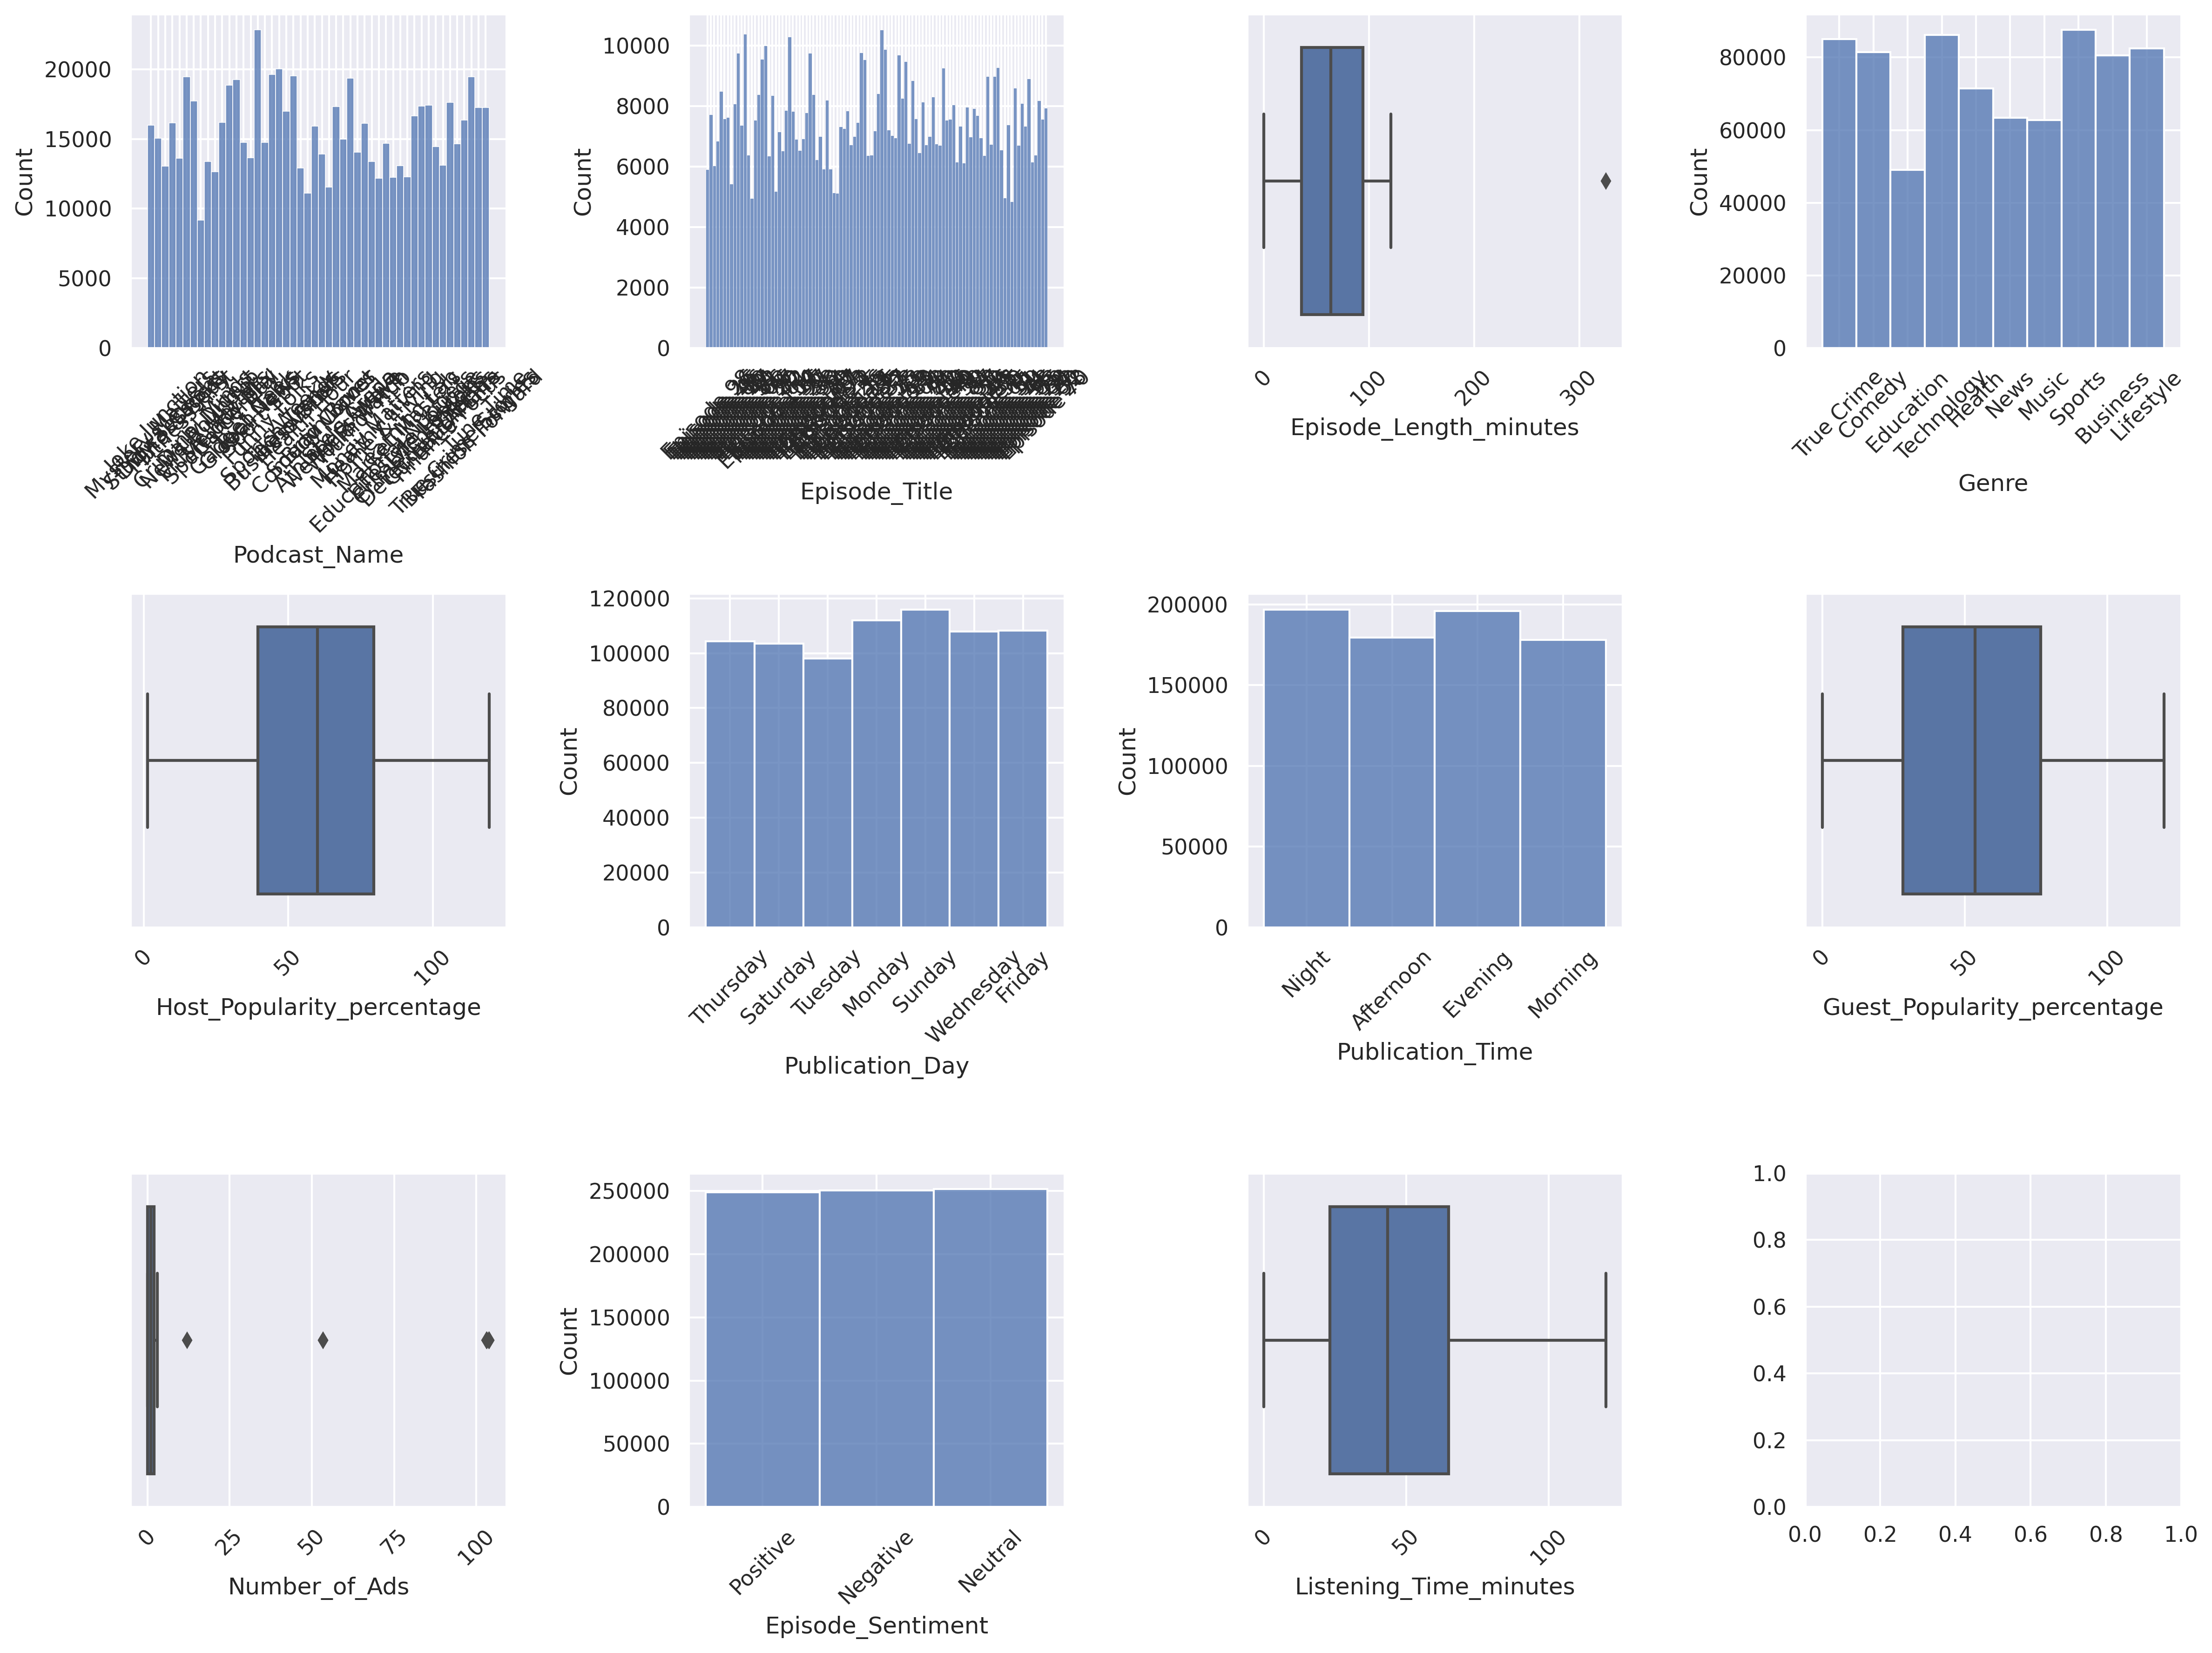

In [4]:
# 分布探索
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12), dpi = 300)
axes = axes.flatten()

for i, column in enumerate(train.columns):
    if column in numerical_features or column == target:
        # 对于连续数据，使用箱线图
        g = sns.boxplot(data=train, x=column, color='b', ax=axes[i])
    else:
        # 对于分类数据，使用直方图
        g = sns.histplot(data=train, x=column, color='b', ax=axes[i])

    locator = axes[i].get_xticks()
    axes[i].xaxis.set_major_locator(plt.FixedLocator(locator))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### 异常值处理

In [5]:
# 异常值处理
for feature in numerical_features:
    Q1 = all_data[feature].quantile(0.25)
    Q3 = all_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 标记异常值
    outliers = (all_data[feature] < lower_bound) | (all_data[feature] > upper_bound)
    outlier_count = outliers.sum()
    outlier_ratio = outliers.mean()
    print(f'{feature} 的异常值个数为: {outlier_count}，异常值比例为: {outlier_ratio:.2%}')


    # 处理异常值，将异常值替换为上下边界值
    all_data[feature] = all_data[feature].clip(lower=lower_bound, upper=upper_bound)

Episode_Length_minutes 的异常值个数为: 3，异常值比例为: 0.00%
Host_Popularity_percentage 的异常值个数为: 0，异常值比例为: 0.00%
Guest_Popularity_percentage 的异常值个数为: 0，异常值比例为: 0.00%
Number_of_Ads 的异常值个数为: 11，异常值比例为: 0.00%


### 缺失值处理
- 缺失比例小于5%中位数插补
- 缺失比例5%～20%中位数插补并标记

In [6]:
# 缺失值处理
print('缺失值情况及比例：')
total_rows = all_data.shape[0]
missing_value_sums = all_data.isnull().sum()
missing_value_proportions = (missing_value_sums / total_rows) * 100

for column, missing_count in missing_value_sums.items():
    proportion = missing_value_proportions[column]
    print(f"{column}: 缺失值数量为 {missing_count}，缺失值比例为 {proportion:.2f}%")
    
# 缺失比例小于5%中位数插补
median_number_of_ads = all_data['Number_of_Ads'].median()
all_data['Number_of_Ads'].fillna(median_number_of_ads, inplace=True)
print(f"已使用中位数 {median_number_of_ads} 插补 Number_of_Ads 的缺失值")  
    
# 缺失比例5%～20%中位数插补并标记
features_to_impute = ['Episode_Length_minutes', 'Guest_Popularity_percentage']

for feature in features_to_impute:
    median_value = all_data[feature].median()
    all_data[f'{feature}_imputed'] = all_data[feature].isnull().astype(int)
    all_data[feature].fillna(median_value, inplace=True)  
    print(f"已使用中位数 {median_value:.2f} 插补 {feature} 的缺失值")
    print(f"{feature} 插补后缺失值比例：{all_data[feature].isnull().mean():.2%}\n")

缺失值情况及比例：
Podcast_Name: 缺失值数量为 0，缺失值比例为 0.00%
Episode_Title: 缺失值数量为 0，缺失值比例为 0.00%
Episode_Length_minutes: 缺失值数量为 115829，缺失值比例为 11.58%
Genre: 缺失值数量为 0，缺失值比例为 0.00%
Host_Popularity_percentage: 缺失值数量为 0，缺失值比例为 0.00%
Publication_Day: 缺失值数量为 0，缺失值比例为 0.00%
Publication_Time: 缺失值数量为 0，缺失值比例为 0.00%
Guest_Popularity_percentage: 缺失值数量为 194862，缺失值比例为 19.49%
Number_of_Ads: 缺失值数量为 1，缺失值比例为 0.00%
Episode_Sentiment: 缺失值数量为 0，缺失值比例为 0.00%
Listening_Time_minutes: 缺失值数量为 250000，缺失值比例为 25.00%
已使用中位数 1.0 插补 Number_of_Ads 的缺失值
已使用中位数 63.87 插补 Episode_Length_minutes 的缺失值
Episode_Length_minutes 插补后缺失值比例：0.00%

已使用中位数 53.54 插补 Guest_Popularity_percentage 的缺失值
Guest_Popularity_percentage 插补后缺失值比例：0.00%



### Label编码
或许更适合Onehot？但是Label的内存或许会小一点

In [7]:
# Label编码
for feature in categorical_features:
    encoder = LabelEncoder()
    all_data[feature] = encoder.fit_transform(all_data[feature].astype(str))

### 数据划分

In [8]:
# 划分数据集
train = all_data[all_data.index < 750000]
test = all_data[all_data.index >= 750000]

# 特征和目标变量
X_train = train.drop(columns=[target])
y_train = train[target]
X_test = test.drop(columns=[target])
y_test = test[target]

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 3 贝叶斯优化XGBoost

In [9]:
# 贝叶斯优化函数
def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda):
    """贝叶斯优化目标函数"""
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'n_estimators': 10000,
        'eval_metric': 'rmse',
        'early_stopping_rounds': 100,
        'tree_method': 'gpu_hist',
        'gpu_id': 0
    }

    cv_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X_train):
        x_tr = X_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        x_va = X_train.iloc[val_idx]
        y_va = y_train.iloc[val_idx]

        model = xgb.XGBRegressor(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_va, y_va)],
            verbose=False
        )

        val_pred = model.predict(x_va)
        val_rmse = mean_squared_error(y_va, val_pred, squared=False)
        cv_scores.append(val_rmse)

    mean_rmse = np.mean(cv_scores)
    print(f"Mean RMSE: {mean_rmse:.3f}")
    return -mean_rmse

# 定义参数空间
pbounds = {
    'max_depth': (5, 12),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'reg_alpha': (0.1, 1),
    'reg_lambda': (0.1, 1)
}

# 运行贝叶斯优化
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=15, n_iter=45)

# 获取最佳参数
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['tree_method'] = 'gpu_hist'
best_params['gpu_id'] = 0
print('最佳参数:', best_params)

|   iter    |  target   | colsam... | learni... | max_depth | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
Mean RMSE: 13.069
| 1         | -13.07    | 0.8749    | 0.2857    | 10.12     | 0.6388    | 0.2404    | 0.8312    |
Mean RMSE: 13.024
| 2         | -13.02    | 0.8116    | 0.2612    | 9.208     | 0.7373    | 0.1185    | 0.994     |
Mean RMSE: 12.937
| 3         | -12.94    | 0.9665    | 0.07158   | 6.273     | 0.2651    | 0.3738    | 0.905     |
Mean RMSE: 12.907
| 4         | -12.91    | 0.8864    | 0.09446   | 9.283     | 0.2255    | 0.3629    | 0.8733    |
Mean RMSE: 13.018
| 5         | -13.02    | 0.8912    | 0.2377    | 6.398     | 0.5628    | 0.6332    | 0.8093    |
Mean RMSE: 12.954
| 6         | -12.95    | 0.9215    | 0.05945   | 5.455     | 0.954     | 0.9691    | 0.9617    |
Mean RMSE: 12.818
| 7         | -12.82    | 0.8609    | 0.03832   | 9.79      | 0.4961    | 0.2098    | 0.89

### 交叉验证

In [10]:
# 5折交叉验证过拟合分析
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
train_rmse_scores = []
val_rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n{'='*20} Fold {fold+1} {'='*20}")
    
    x_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    x_va = X_train.iloc[val_idx]
    y_va = y_train.iloc[val_idx]

    model = xgb.XGBRegressor(
        **best_params,
        n_estimators=10000,
        early_stopping_rounds=100,
        eval_metric='rmse'
    )
    
    model.fit(
        x_tr, y_tr,
        eval_set=[(x_va, y_va)],
        verbose=100
    )
    
    # 训练集预测
    train_pred = model.predict(x_tr)
    train_rmse = mean_squared_error(y_tr, train_pred, squared=False)
    
    # 验证集预测
    val_pred = model.predict(x_va)
    val_rmse = mean_squared_error(y_va, val_pred, squared=False)
    
    # 记录结果
    train_rmse_scores.append(train_rmse)
    val_rmse_scores.append(val_rmse)
    
    print(f"Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")


==================== Fold 1 ====================
[0]	validation_0-rmse:26.89873
[100]	validation_0-rmse:16.08189
[200]	validation_0-rmse:13.62304
[300]	validation_0-rmse:13.08827
[400]	validation_0-rmse:12.93034
[500]	validation_0-rmse:12.87680
[600]	validation_0-rmse:12.84707
[700]	validation_0-rmse:12.82526
[800]	validation_0-rmse:12.80860
[900]	validation_0-rmse:12.79641
[1000]	validation_0-rmse:12.78335
[1100]	validation_0-rmse:12.77234
[1200]	validation_0-rmse:12.76173
[1300]	validation_0-rmse:12.75361
[1400]	validation_0-rmse:12.74664
[1500]	validation_0-rmse:12.73751
[1600]	validation_0-rmse:12.72978
[1700]	validation_0-rmse:12.72294
[1800]	validation_0-rmse:12.71751
[1900]	validation_0-rmse:12.71237
[2000]	validation_0-rmse:12.70636
[2100]	validation_0-rmse:12.70142
[2200]	validation_0-rmse:12.69639
[2300]	validation_0-rmse:12.69253
[2400]	validation_0-rmse:12.68832
[2500]	validation_0-rmse:12.68403
[2600]	validation_0-rmse:12.68066
[2700]	validation_0-rmse:12.67783
[2800]	val

### 过拟合分析
写错了好像

In [11]:
# 过拟合诊断
mean_train_rmse = np.mean(train_rmse_scores)
mean_val_rmse = np.mean(val_rmse_scores)
overfit_gap = mean_train_rmse - mean_val_rmse

print("\n" + "="*50)
print(f"Average Training RMSE:   {mean_train_rmse:.4f}")
print(f"Average Validation RMSE: {mean_val_rmse:.4f}")
print(f"Overfitting Gap:        {overfit_gap:.4f}")

# 过拟合程度判断
if overfit_gap > 0.05:
    print("\n⚠️ 警告：检测到严重过拟合！")
    print("建议操作：")
    print("- 增加正则化系数（reg_alpha/reg_lambda）")
    print("- 降低max_depth")
    print("- 使用更多训练数据")
    print("- 进行特征筛选")
elif overfit_gap > 0.02:
    print("\nℹ️ 注意：中度过拟合")
    print("建议尝试：")
    print("- 适度增加正则化")
    print("- 减少树的数量")
else:
    print("\n✅ 模型泛化性能良好")


Average Training RMSE:   6.6991
Average Validation RMSE: 12.6931
Overfitting Gap:        -5.9940

✅ 模型泛化性能良好


## 4 训练与提交

[0]	validation_0-rmse:26.89066
[100]	validation_0-rmse:16.08323
[200]	validation_0-rmse:13.62551
[300]	validation_0-rmse:13.09044
[400]	validation_0-rmse:12.93194
[500]	validation_0-rmse:12.87806
[600]	validation_0-rmse:12.84620
[700]	validation_0-rmse:12.82506
[800]	validation_0-rmse:12.80739
[900]	validation_0-rmse:12.79457
[1000]	validation_0-rmse:12.78096
[1100]	validation_0-rmse:12.76857
[1200]	validation_0-rmse:12.75746
[1300]	validation_0-rmse:12.74677
[1400]	validation_0-rmse:12.73720
[1500]	validation_0-rmse:12.72656
[1600]	validation_0-rmse:12.71740
[1700]	validation_0-rmse:12.70892
[1800]	validation_0-rmse:12.70126
[1900]	validation_0-rmse:12.69313
[2000]	validation_0-rmse:12.68602
[2100]	validation_0-rmse:12.67943
[2200]	validation_0-rmse:12.67306
[2300]	validation_0-rmse:12.66757
[2400]	validation_0-rmse:12.66137
[2500]	validation_0-rmse:12.65549
[2600]	validation_0-rmse:12.65039
[2700]	validation_0-rmse:12.64543
[2800]	validation_0-rmse:12.63994
[2900]	validation_0-rmse:1

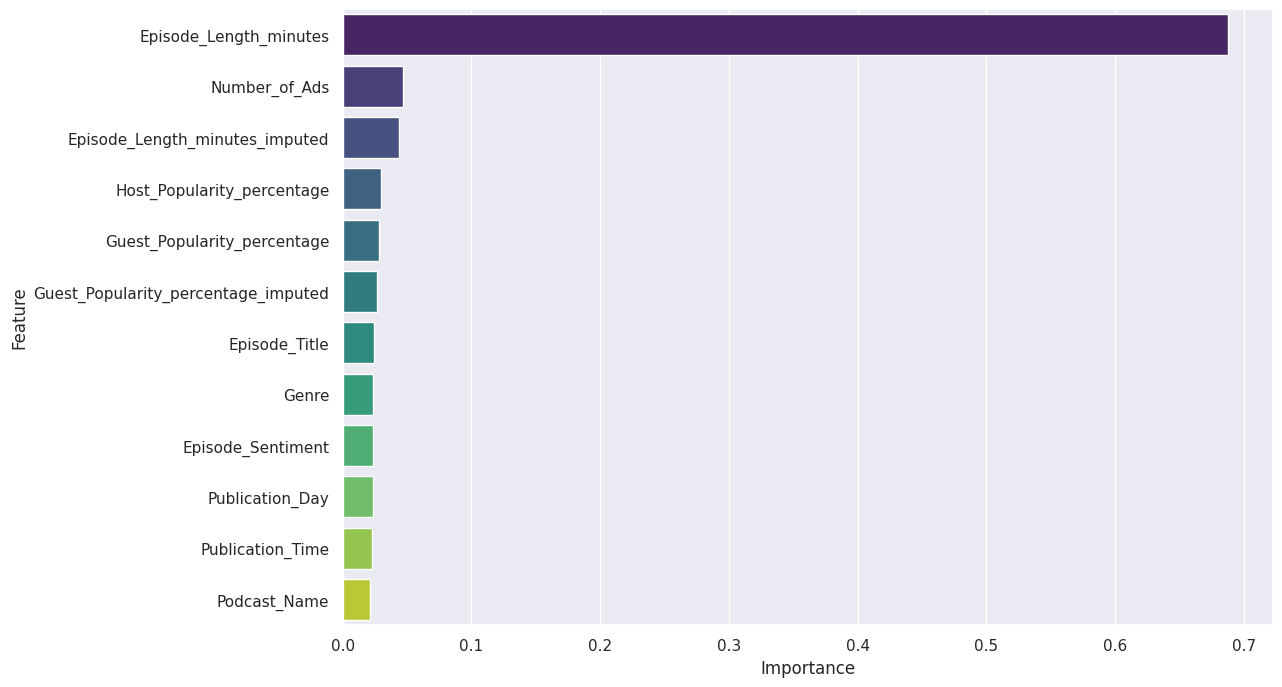

In [12]:
# 最终模型训练
final_model = xgb.XGBRegressor(
    **best_params,
    n_estimators=10000,
    early_stopping_rounds=100,
    eval_metric='rmse'
).fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

# 特征重要性可视化
feature_importance = final_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.show()

In [13]:
# 预测
xgb_pred = final_model.predict(X_test)
submission = pd.DataFrame({
    'id': test.index,
    'Listening_Time_minutes': xgb_pred
})
submission.to_csv('submission.csv', index=False)